In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import ray
from ray.rllib.agents import ppo

from mdps.whited_CEF import cMDPWhited_CEF
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [2]:
# collect expert rollout

def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPWhited_CEF(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = obs_
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
        if gt_act_arr_ is None:
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_[1:,:], gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:,0], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Capital(k)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

    fig_, ax_3 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_4 = ax_3.twinx()
    ax_3.plot(x, gt_obs_arr_[:,1], 'r-')
    ax_4.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_3.set_xlabel('time step')
    ax_3.set_ylabel('Shock(z)', color='r')
    ax_4.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

In [3]:
c = {"context_distribution":
        ConstantDistribution(dim=7, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15, 0.08, 0.028]))
    }

ray.shutdown()
ray.init()

expert = ppo.PPOTrainer(env=cMDPWhited_CEF, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(40):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-02-28 21:06:43,930	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-28 21:06:43,930	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-02-28 21:06:46,007	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-02-28 21:06:54,904	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 525994658537.0x the scale of `vf_clip_param`. This means that it will take more than 525994658537.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


0 -5259946585370.263


2022-02-28 21:07:03,802	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 277714900764.0x the scale of `vf_clip_param`. This means that it will take more than 277714900764.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-28 21:07:12,592	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 190684613826.0x the scale of `vf_clip_param`. This means that it will take more than 190684613826.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-28 21:07:21,423	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 7072840642.0x the scale of `vf_clip_param`. This means that it will take more than 7072840642.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-28 21:07:30,239	WARNING ppo.py:245 -- The magnitude of your 

5 -134131542.68160208


2022-02-28 21:07:47,609	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 6186344.0x the scale of `vf_clip_param`. This means that it will take more than 6186344.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-28 21:07:56,327	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 128151.0x the scale of `vf_clip_param`. This means that it will take more than 128151.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-28 21:08:05,050	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 29132.0x the scale of `vf_clip_param`. This means that it will take more than 29132.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-28 21:08:13,839	WARNING ppo.py:245 -- The magnitude of your environment rewards are more tha

10 -4989.886851818273
15 625.4304048728127
20 768.5552751013546
25 818.2706634340517
30 830.1145012497883
35 837.6762379245483


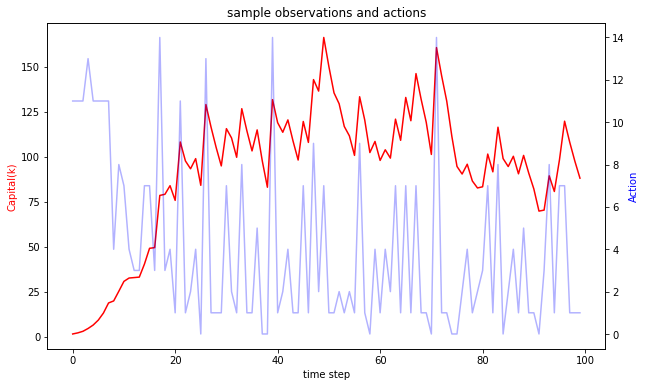

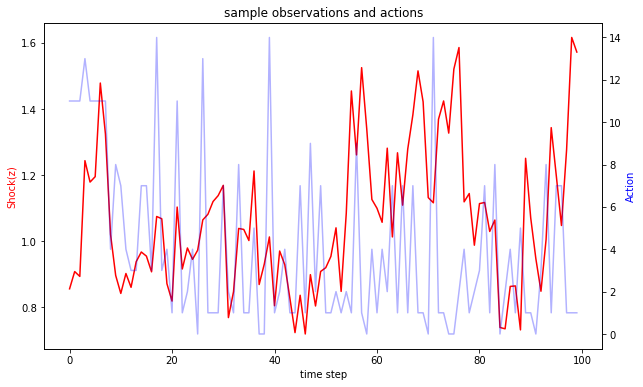

In [34]:
c_sim = {"context_distribution":
        ConstantDistribution(dim=7, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15, 0.08, 0.028]))
        }
        
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c_sim)
plot_rollouts(gt_obs_arr, gt_act_arr)

In [35]:
np.save("gtobs_whited_CEF.npy", gt_obs_arr)
np.save("gtact_whited_CEF.npy", gt_act_arr)
np.save("gtrew_whited_CEF.npy", gt_rew_arr)

In [36]:
gt_act_arr = np.load("gtact_whited_CEF.npy")
gt_obs_arr = np.load("gtobs_whited_CEF.npy")
gt_rew_arr = np.load("gtrew_whited_CEF.npy")

In [48]:
# use solver
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.ones((N_,2))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                           ConstantDistribution(dim=7,
                                                constant_vector=context_)
            }
            env_ = cMDPWhited_CEF(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate((np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            q = env_.likelihood(gt_obs_arr_[t_], action_arr_[n_], obs_, reward_)
            qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.25
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(context_distribution_.particles, 0.0, 0.5)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 4].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

2022-02-28 23:54:08,044	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-02-28 23:54:16,941	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 2277045456714.0x the scale of `vf_clip_param`. This means that it will take more than 2277045456714.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-28 23:54:25,806	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1151508064551.0x the scale of `vf_clip_param`. This means that it will take more than 1151508064551.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-28 23:54:34,252	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 635239115946.0x the scale of `vf_clip_param`. This means that it will take more than 635239115946.0 iterations for your value function to converge. If this is not intended, consider 

round 0 posterior mean 0.2521184903834487
round 25 posterior mean 0.07214823507749968
round 50 posterior mean 0.07307039756517154
round 75 posterior mean 0.07196542102560423


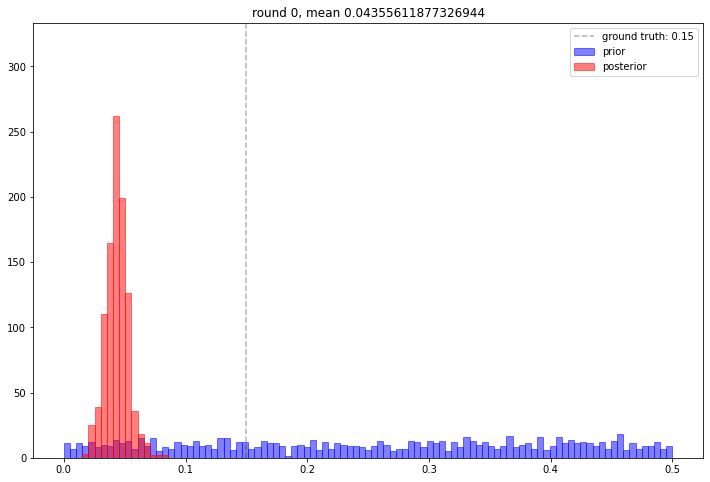

round 0 posterior mean 0.04355611877326944
round 25 posterior mean 0.06546719219558275
round 50 posterior mean 0.1080100200135295
round 75 posterior mean 0.12160701902445178


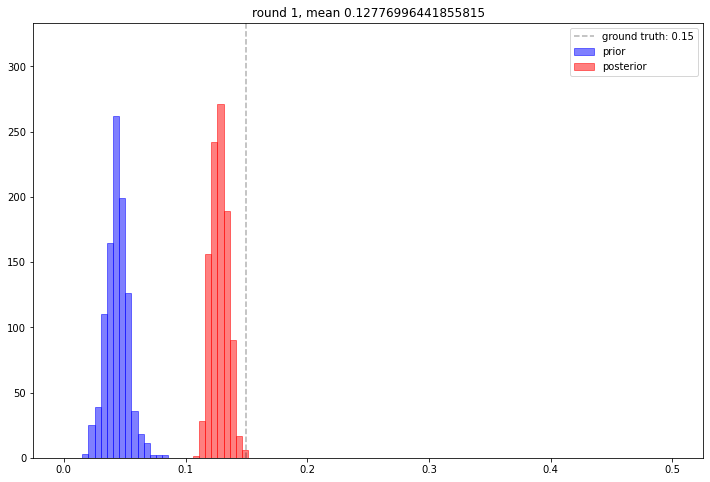

round 0 posterior mean 0.12776996441855815
round 25 posterior mean 0.12885758051574492
round 50 posterior mean 0.15978822965696565
round 75 posterior mean 0.18950612645268444


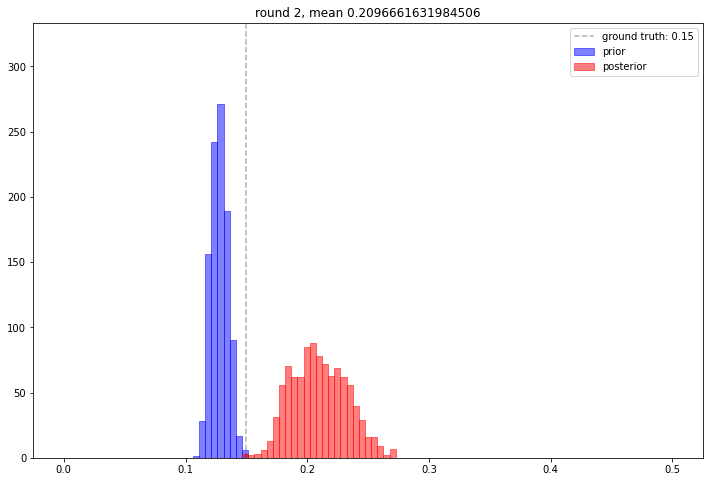

(pid=None) [2022-03-01 18:53:57,195 C 45628 24312] redis_client.cc:87:  Check failed: under_retry_limit Expected 1 Redis shard addresses, found 7
(pid=None) *** StackTrace Information ***
(pid=None)     recalloc
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
(pid=None) [2022-03-01 18:54:03,407 E 43576 41640] local_object_manager.cc:32: Plasma object ffffffffffffffffffffffffffffffffffffffff0100000001000000 was evicted before the raylet could pin it.
(pid=None) [2022-03-01 18:54:03,416 C 43576 41640] local_object_manager.cc:88:  Check failed: (pinned_objects_.count(object_id) > 0) || (spilled_objects_url_.count(object_id) > 0) || (objects_pending_spill_.count(object_id) > 0) 
(pid=None) *** StackTrace Information ***
(pid=None)     BaseThreadInitThunk
(pid=None)     RtlUserThreadStart
(pid=None) 
2022-03-01 18:54:33,643	WARNING worker.py:1245 -- The node with node id: b0d8c9596be5d846d9e46378aaf798558480b8d43768bce90dd3a636 and ip: 127.0.0.1 has been mar

In [49]:
# Initialize prior

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
# theta = np.random.uniform(0.6, 1.0, size=(N,))
rho = np.ones((N,)) * 0.7
# rho = np.random.uniform(0.6, 1.0, size=(N,))
# sigma = np.ones((N,)) * 0.15
sigma = np.random.uniform(0.0, 0.5, size=(N,))
eta_0 = np.ones((N,)) * 0.08
eta_1 = np.ones((N,)) * 0.028

prior_context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma, eta_0, eta_1)).T)
imp_context_distribution = ParticleDistribution(dim=7, particles=prior_context_particles, n_particles=N)

ray.shutdown()
ray.init()

imp_solver = ppo.PPOTrainer(env=cMDPWhited_CEF, config={
                                                "env_config":  {"context_distribution": imp_context_distribution},
                                                "framework": "torch",  # config to pass to env class
                                            })

for update_round in range(3):
    # burn in training
    if update_round == 0:
        for i in range(20):
            imp_solver.train()

    context_history_imp, imp_context_distribution = filter_context(imp_solver,
                                       imp_context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

    fig, ax = plt.subplots()
    HIST_BINS = np.linspace(0.0, 0.5, 100)
    ax.hist(context_history_imp[0][:, 4], HIST_BINS, lw=1,
            ec="blue", fc="blue", alpha=0.5)
    ax.hist(context_history_imp[-1][:, 4], HIST_BINS, lw=1,
            ec="red", fc="red", alpha=0.5)
    plt.axvline(x=0.15, alpha=0.3, color='black', linestyle='--')
    plt.legend(['ground truth: 0.15', 'prior', 'posterior'])
    ax.set_ylim(top=N / 3)
    fig.set_size_inches(12, 8)
    plt.title(f'round {update_round}, mean {context_history_imp[-1][:, 4].mean()}')
    plt.show()

    imp_solver.workers.foreach_worker(
                lambda ev: ev.foreach_env(
                    lambda env: env.set_task(imp_context_distribution)))
    for _ in range(5):
        imp_solver.train()
